In [6]:
    import hopsworks
    import pandas as pd
    from sklearn.ensemble import HistGradientBoostingClassifier
    # from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os

In [7]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/196769
Connected. Call `.close()` to terminate connection gracefully.


In [8]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=4)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=4,
                                  description="Read from wine dataset",
                                  labels=["quality"],
                                  query=query)
# pay attention to version

In [45]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

# Train our model with the HistGradientBoostingClassifier using our features (X_train) and labels (y_train)
model = HistGradientBoostingClassifier(l2_regularization=3, max_iter=72, learning_rate=0.18)
# from sklear library and is based on histogram-based gradient boosting
model.fit(X_train, y_train.values.ravel())
# ravel() is used to convert the target variable to a flattened one-dimensional array

"""
We have tried KNeighborsClassifier and the accurancy is about 0.4, it's kind of unacceptable.

Then we try HistGradientBoostingClassifier, and here are some details:
l2_regularization: It controls the strength of L2 regularization, which helps prevent overfitting by penalizing large coefficients.
max_iter: It determines the maximum number of boosting iterations.
learning_rate: It scales the contribution of each tree in the ensemble.

We simply adjusted the parameters. The accurancy increase to more than 0.5. At least it,s better than before.

Another difference is that when we use k-neighbors, the number of P5T6 are huge. Almost the same as the P6T6.
But now the wrong predictions are averaged to P6T5 P6T7.
"""

Finished: Reading data from Hopsworks, using ArrowFlight (3.69s) 


HistGradientBoostingClassifier(l2_regularization=3, learning_rate=0.18,
                               max_iter=72)

In [46]:
X_train

,volatile_acidity,chlorides,density,alcohol
0,0.400000,0.071000,0.994620,12.500000
1,0.320000,0.043000,0.992660,11.200000
2,0.300000,0.046000,0.997750,9.500000
3,0.400000,0.046000,0.990240,12.000000
4,0.450000,0.080000,0.995600,9.400000
...,...,...,...,...
5280,0.670000,0.290000,0.998400,9.000000
5282,0.190075,0.117168,0.989639,8.679233
5283,0.170769,0.098561,0.995772,9.939826
5284,0.511997,0.048713,1.000273,11.491108


In [47]:
y_train

,quality
0,8
1,6
2,6
3,7
4,5
...,...
5280,4
5282,6
5283,7
5284,5


In [48]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [49]:
print(metrics)

{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, '4': {'precision': 0.2, 'recall': 0.06666666666666667, 'f1-score': 0.1, 'support': 45}, '5': {'precision': 0.5333333333333333, 'recall': 0.5818181818181818, 'f1-score': 0.5565217391304348, 'support': 330}, '6': {'precision': 0.5330948121645797, 'recall': 0.6195426195426196, 'f1-score': 0.573076923076923, 'support': 481}, '7': {'precision': 0.44545454545454544, 'recall': 0.28, 'f1-score': 0.34385964912280703, 'support': 175}, '8': {'precision': 0.15384615384615385, 'recall': 0.08333333333333333, 'f1-score': 0.10810810810810811, 'support': 24}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'accuracy': 0.5141776937618148, 'macro avg': {'precision': 0.2665326921140875, 'recall': 0.23305154305154302, 'f1-score': 0.24022377420546756, 'support': 1058}, 'weighted avg': {'precision': 0.4943907918695804, 'recall': 0.5141776937618148, 'f1-score': 0.4977052997203491, 'support': 1058}}


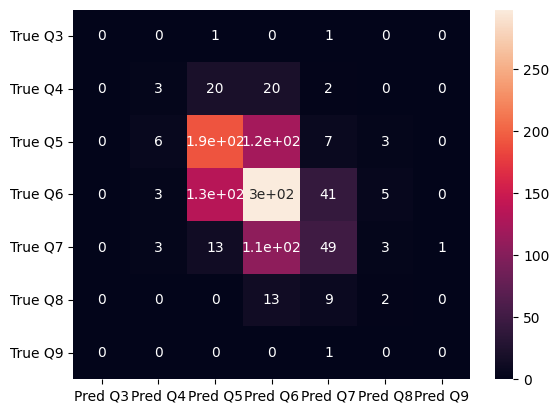

In [50]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True Q3', 'True Q4', 'True Q5', 'True Q6', 'True Q7', 'True Q8', 'True Q9'],
                     ['Pred Q3', 'Pred Q4', 'Pred Q5', 'Pred Q6', 'Pred Q7', 'Pred Q8', 'Pred Q9'])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [51]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/wine_confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/196769/models/wine_model/3


Model(name: 'wine_model', version: 3)